In [2]:
# Importing librairies

import csv
import matplotlib.pyplot as plt
from collections import Counter
import operator
import numpy as np
import pandas as pd
from random import randrange
import random
from PIL import Image
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_clothing = ['t-shirt/top','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']

In [3]:
def get_dataset(csvfile):
    
    dataset = []
    labels = []
    
    with open(csvfile) as f:
        file = f.readlines()
        f.close()
    
    for item in file:
        img = {}
        list_pixels = []
        label = item[0]
        labels.append(label)
        
        list_pixels = [int(pixel) for pixel in item.split(',')[1:]]
        img[label] = list_pixels
            
        dataset.append(img)
    
    return dataset, labels

train, labels_train = get_dataset("mnist_train.csv")
test, labels_test = get_dataset("mnist_test.csv")

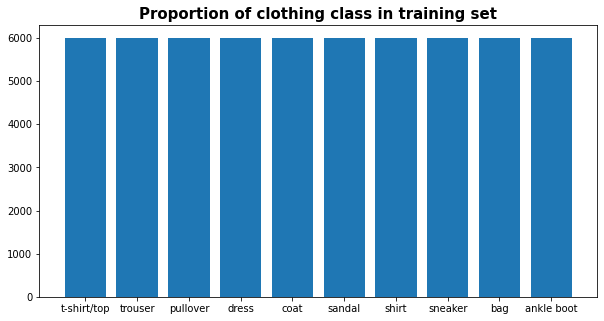

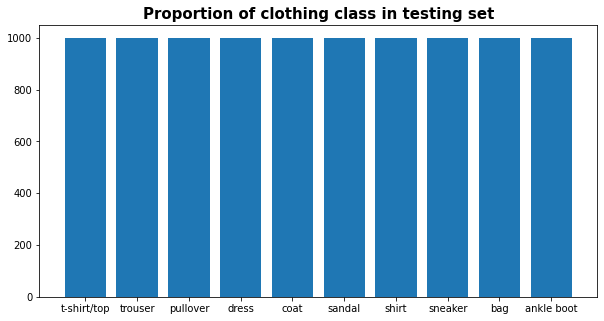

In [4]:
def show_frequency(dataset, title):
    """Shows clothing class in dataset as a figure.
    
    Parameters
    ----------
    dataset : list
        List of clothing object.
    """
    # Showing figure
    fd = nltk.FreqDist(dataset)
    all_fdist = pd.Series(dict(fd))
    plt.subplots(figsize=(10,5))
    plt.bar(label_clothing, all_fdist)
    plt.title(title,fontweight="bold", size=15)
    plt.show()

show_frequency(labels_train, "Proportion of clothing class in training set")
show_frequency(labels_test, "Proportion of clothing class in testing set")

In [5]:
def processing_dataset(df,usage):
    
    x = []
    y = []

    for item in df:
        
        # item.values() contains a class integer and a list of pixels
        for clothing_class, pixels in item.items():

            # clothing contains the clothing class (from 0 to 9)
            y.append(clothing_class)

            pixels = np.array(pixels).reshape((1, 28, 28))
            x.append(pixels)

    # We return numpy arrays
    x = np.array(x).reshape((len(x),1, 28, 28))
    y = np.array(y, dtype = 'int64')
    
    return x, y

x_train, y_train = processing_dataset(train,'Training')
x_test, y_test = processing_dataset(test,'PublicTest')

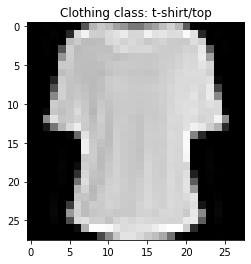

In [6]:
# We convert a set of pixels from the train dataset
# into an image to see how it looks like

def show_image(random_image):

    # We flatten and transform our numpy array into a list
    # because the pixels are not ordered as a 28 * 28 image
    # so we need to process them
    pixels_example = x_train[random_image].flatten()
    pixels_example = pixels_example.tolist()

    # We check the labeled clothing object
    clothing_example = y_train[random_image]
    title = "Clothing class: "+str(label_clothing[int(clothing_example)])

    # We order the pixels as a 28 * 28 image and convert it
    # into a numpy array
    n = 28
    pixels_example = list(map(int, pixels_example))
    image_example = [pixels_example[i:i + n] for i in range(0, len(pixels_example), n)]
    image_example = np.array(image_example, dtype=np.uint8)
    # We pick 1 because our images are in gray
    image_example.shape == (28, 28, 1)

    # We show the image
    img = Image.fromarray(image_example)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()
    
# We pick a random number as one image in the train dataset
random_image = randrange(len(x_train))
show_image(random_image)

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN, self).__init__()

        # CONV => RELU => POOL => BATCH => DROPOUT layers
        
        # We have 1 channel because the pixels are grey
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            nn.BatchNorm2d(8),
            nn.Dropout(0.25)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            nn.BatchNorm2d(16),
            nn.Dropout(0.25)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25)
        )
       
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
        )
        self.fc1 = nn.Linear(128*12*12,1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 10)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.log_softmax = nn.LogSoftmax(dim=1)
        

    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        x = x.view(-1,128*12*12)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.log_softmax(x)
        
        return x

In [8]:
def data_loader(x_data, y_data):
    data = []
    for i in range(len(x_data)):
        data.append([x_data[i], y_data[i]])
    
    dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
    return dataloader

def train(model,dataloader,epochs,loss_fn,optimizer):
    model.train()
    print("Training model ...\n")
    train_accuracy = []
    train_losses = []
    predictions = []
    
    for e in range(epochs):
        total_loss = 0
        total = 0
        correct = 0
        
        for i, (x, y) in enumerate(dataloader):
            
            x = x.float()
            x, y = x.to(device), y.to(device)

            output = model(x)
            
            loss = loss_fn(output, y)
            total_loss += loss.item()
            
            _, predicted = output.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
            
            print("Total loss in epoch {} is {}".format(e, total_loss/(i+1)), end='\r')
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print()
    
        train_loss = total_loss / len(dataloader)
        train_losses.append(train_loss)
        accuracy = 100. * correct / total
        train_accuracy.append(accuracy)
        
    print("Train accuracy is ", accuracy)
    return model, train_accuracy, train_losses

def test(model,dataloader,epochs,loss_fn,optimizer):
    print("Testing model ...\n")
    test_accuracy = []
    test_losses = []
    
    # switch off autograd for evaluation
    for e in range(epochs):
        total_loss = 0
        total = 0
        correct = 0
        with torch.no_grad():
            model.eval()

            for i, (x, y) in enumerate(dataloader):

                x = x.float()
                x, y = x.to(device), y.to(device)

                output = model(x)

                total_loss += loss_fn(output, y).item()
                
                _, predicted = output.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()
                
                print("Total loss in epoch {} is {}".format(e, total_loss/(i+1)), end='\r')
                
            print()
        
        test_loss = total_loss / len(dataloader)
        test_losses.append(test_loss)
        accuracy = 100. * correct / total
        test_accuracy.append(accuracy)

    print("Test accuracy is ", accuracy)
    return test_accuracy, test_losses

In [9]:
# We set the hyperparameters
BATCH_SIZE = 128
EPOCHS = 10
LR = 0.001
loss_fn = nn.CrossEntropyLoss()
CNN_model = CNN().to(device)
optimizer = optim.Adam(CNN_model.parameters(), lr=LR)

In [10]:
# Loading processed datasets
train_loader = data_loader(x_train,y_train)
test_loader = data_loader(x_test,y_test)

In [11]:
# Training model
# We use train_loader which contains the training set
# in order to train our model
model, trained_accu, trained_losses = train(CNN_model,train_loader,EPOCHS,loss_fn,optimizer)

# Save model
torch.save(model, "model_cnn.pt")

Training model ...

Total loss in epoch 0 is 0.43654465732543965
Total loss in epoch 1 is 0.30519761278558133
Total loss in epoch 2 is 0.26943152499542056
Total loss in epoch 3 is 0.23946358638404538
Total loss in epoch 4 is 0.21505737803511019
Total loss in epoch 5 is 0.19334669423891282
Total loss in epoch 6 is 0.17886887875987267
Total loss in epoch 7 is 0.16537364308577357
Total loss in epoch 8 is 0.14581946293904838
Total loss in epoch 9 is 0.12987375874985765
Train accuracy is  95.195


In [12]:
# Load model
model = torch.load("model_cnn.pt").to(device)

# Testing model
# We use test_loader which contains the testing set
# in order to test our model
tested_accu, tested_losses = test(CNN_model,test_loader,EPOCHS,loss_fn,optimizer)

Testing model ...

Total loss in epoch 0 is 0.28414967142213493
Total loss in epoch 1 is 0.28522915581736386
Total loss in epoch 2 is 0.28445001154006283
Total loss in epoch 3 is 0.28771385475050043
Total loss in epoch 4 is 0.28804470410075367
Total loss in epoch 5 is 0.28538207615478134
Total loss in epoch 6 is 0.29493503225377843
Total loss in epoch 7 is 0.28481593482856516
Total loss in epoch 8 is 0.28671357497761524
Total loss in epoch 9 is 0.28416355666586585
Test accuracy is  92.43


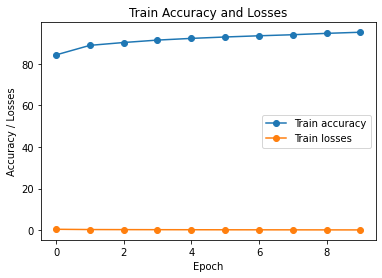

In [14]:
plt.plot(trained_accu,'-o')
plt.plot(trained_losses,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Losses')
plt.legend(['Train accuracy','Train losses'])
plt.title('Train Accuracy and Losses')

plt.show()

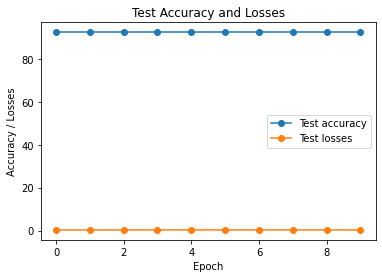

In [15]:
plt.plot(tested_accu,'-o')
plt.plot(tested_losses,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Losses')
plt.legend(['Test accuracy','Test losses'])
plt.title('Test Accuracy and Losses')

plt.show()

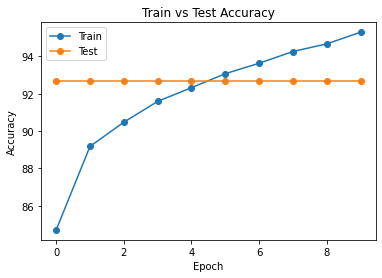

In [28]:
plt.plot(trained_accu,'-o')
plt.plot(tested_accu,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')

plt.show()

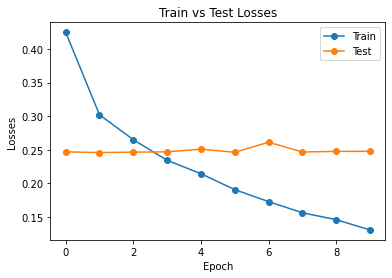

In [29]:
plt.plot(trained_losses,'-o')
plt.plot(tested_losses,'-o')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')

plt.show()

In [30]:
def show_model(model, dataloader):
    predictions = []
    with torch.no_grad():
        
        model.eval()
        
        for i, (x, y) in enumerate(dataloader):
            x = x.float()
            (x, y) = (x.to(device), y.to(device))
            output = model(x)
            
            x = x.detach().squeeze().cpu().numpy()
            truth = y.detach().cpu().numpy()
            
            _, predicted = output.max(1)
            predictions += list(zip(*[predicted,truth,x]))
            
    example = random.choice(range(0, 168))
    
    result_example = predictions[example]
    example_pred = result_example[0].cpu()
    example_truth = result_example[1]
    example_img = result_example[2]
 
    title_img = "Clothing class: "+str(label_clothing[int(example_truth)])+"\nPredicted clothing: "+str(label_clothing[int(example_pred)])
    plt.figure()
    plt.title(title_img)
    plt.imshow(example_img, cmap='gray')

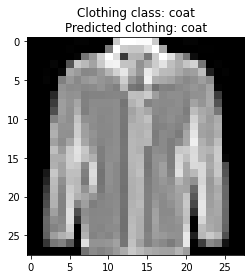

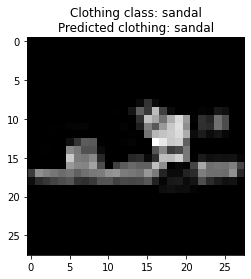

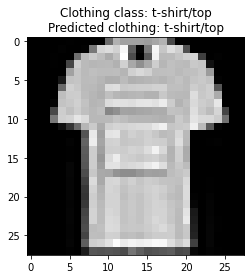

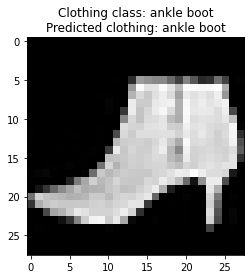

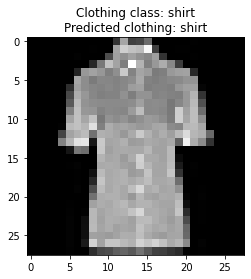

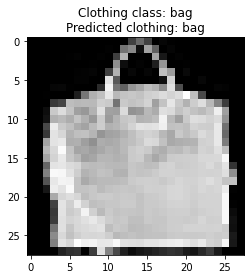

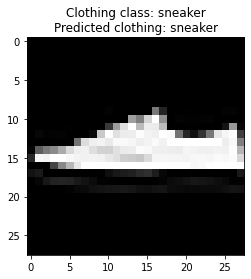

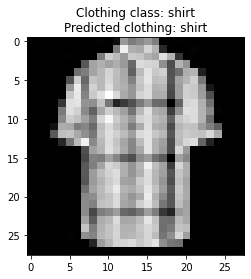

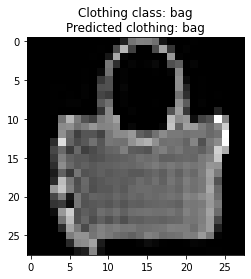

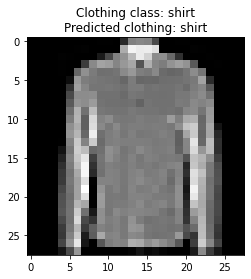

In [31]:
# Random sample of predicted output by test model
n = 10
while n>0:
    show_model(CNN_model, test_loader)
    n = n-1